## **Python for Quantitative Trading: Futures**
### **Integrated CTA Strategies Episode 7 - Linear Regression Model**

In [1]:
import numpy as np
import pandas as pd
import math
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

import os
from helper import *
from stats import *
from product_info import *
import helper
import stats
import dask
from dask import compute, delayed


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号


c:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
from imp import reload  
reload(helper)
reload(stats)

<module 'stats' from 'e:\\My_Strategies_CTA\\stats.py'>

In [3]:
HEAD_PATH = r"E:\My_Strategies_CTA" 
DATA_PATH = HEAD_PATH + "\\pkl_tick" 
NIGHT_PATH = HEAD_PATH + "\\night_pkl_tick\\"
SAVE_PATH = r"E:\My_Strategies_CTA"  #保存计算的因子数据的地方
SIGNAL_PATH = r"E:\My_Strategies_CTA" 
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [4]:
product_list = ["rb", "hc", "i", "j", "jm"]
product = product_list[0] #随便取一个商品期货，可以更改
print(product)
all_dates = os.listdir(DATA_PATH + "\\" + product)
all_dates.sort()
n_days = len(all_dates)
print(len(all_dates), all_dates[:6])

rb
1063 ['20170103.pkl', '20170104.pkl', '20170105.pkl', '20170106.pkl', '20170109.pkl', '20170110.pkl']


In [5]:
period = 4096

# train and test
train_sample = np.array(all_dates) < "2019"
test_sample = np.array(all_dates) > "2019"

# 记录时间的字符串和时间格式
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])


In [6]:
os.makedirs(HEAD_PATH+"\\all_signals", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)

In [7]:
signal_list = [signal+".4096" for signal in all_signal_list]
signal_list

['trade.imb.4096',
 'total.trade.imb.4096',
 'nr.4096',
 'dbook.4096',
 'range.pos.4096',
 'price.osci.4096',
 'ma.dif.10.4096',
 'kdj.k.4096',
 'kdj.j.4096',
 'trade.imb.range.4096',
 'total.trade.imb.range.4096',
 'nr.range.4096',
 'dbook.range.4096',
 'range.pos.range.4096',
 'price.osci.range.4096',
 'ma.dif.10.range.4096',
 'kdj.k.range.4096',
 'kdj.j.range.4096',
 'trade.imb.std.4096',
 'total.trade.imb.std.4096',
 'nr.std.4096',
 'dbook.std.4096',
 'range.pos.std.4096',
 'price.osci.std.4096',
 'ma.dif.10.std.4096',
 'kdj.k.std.4096',
 'kdj.j.std.4096',
 'trade.imb.volume.open.ratio.4096',
 'total.trade.imb.volume.open.ratio.4096',
 'nr.volume.open.ratio.4096',
 'dbook.volume.open.ratio.4096',
 'range.pos.volume.open.ratio.4096',
 'price.osci.volume.open.ratio.4096',
 'ma.dif.10.volume.open.ratio.4096',
 'kdj.k.volume.open.ratio.4096',
 'kdj.j.volume.open.ratio.4096',
 'trade.imb.trend.index.4096',
 'total.trade.imb.trend.index.4096',
 'nr.trend.index.4096',
 'dbook.trend.index.

In [8]:
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])

array(['trade.imb.4096', 'total.trade.imb.4096', 'nr.4096', 'dbook.4096',
       'range.pos.4096', 'price.osci.4096', 'ma.dif.10.4096',
       'kdj.k.4096', 'kdj.j.4096', 'trade.imb.range.4096',
       'total.trade.imb.range.4096', 'nr.range.4096', 'dbook.range.4096',
       'range.pos.range.4096', 'price.osci.range.4096',
       'ma.dif.10.range.4096', 'kdj.k.range.4096', 'kdj.j.range.4096',
       'trade.imb.std.4096', 'total.trade.imb.std.4096', 'nr.std.4096',
       'dbook.std.4096', 'range.pos.std.4096', 'price.osci.std.4096',
       'ma.dif.10.std.4096', 'kdj.k.std.4096', 'kdj.j.std.4096',
       'trade.imb.volume.open.ratio.4096',
       'total.trade.imb.volume.open.ratio.4096',
       'nr.volume.open.ratio.4096', 'dbook.volume.open.ratio.4096',
       'range.pos.volume.open.ratio.4096',
       'price.osci.volume.open.ratio.4096',
       'ma.dif.10.volume.open.ratio.4096', 'kdj.k.volume.open.ratio.4096',
       'kdj.j.volume.open.ratio.4096', 'trade.imb.trend.index.4096',
      

In [9]:
data = load(DATA_PATH + "\\" + product + "\\" + all_dates[9])

In [10]:
sample_y = fcum(data["ret"], period)

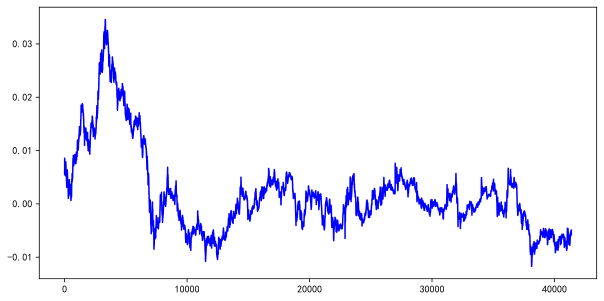

In [11]:
plt.figure(1, figsize=(10, 5))
plt.plot(sample_y[data["good"]].values, color="b")

In [12]:
kurtosis(sample_y[data["good"]], fisher=False)

5.691698128626598

In [13]:
np.sum(data["ret"][3000:(3000+period)])

-0.0005674729038798272

In [14]:
sample_y[2999]

-0.0005674729038798237

In [15]:
class factor_ret_period(factor_template):
    factor_name = "ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return fcum(data["ret"],period).values
    
y1 = factor_ret_period()

In [16]:
for product in product_list:
    create_signal_path(y1, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\ret.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\ret.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\ret.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\ret.4096
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\ret.4096


In [17]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+ "\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y1, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 1min 57s


In [18]:
%%time
for product in product_list:
    parLapply(CORE_NUM, ["ret.4096"], par_get_all_signal, file_list=all_dates, product=product, period=4096, SAVE_PATH=SAVE_PATH)

Wall time: 33.2 s


In [19]:
all_signal = load(SAVE_PATH+"\\all_signals\\"+ product_list[0]+ ".ret."+str(period)+".pkl")

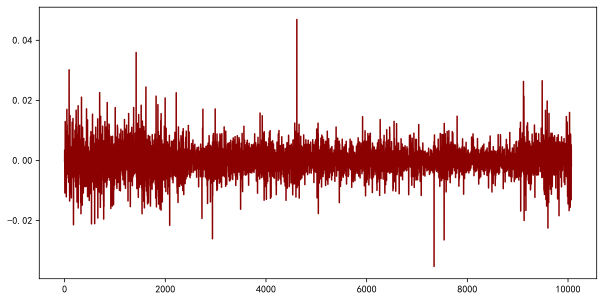

In [20]:
plt.figure(1, figsize=(10, 5))
plt.plot(all_signal, color="darkred")

In [21]:
print("kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))


kurtosis= 11.428722751865607  skew= 0.1870508078190509


kurtosis= 6.371241126851522  skew= -0.09947963185047914


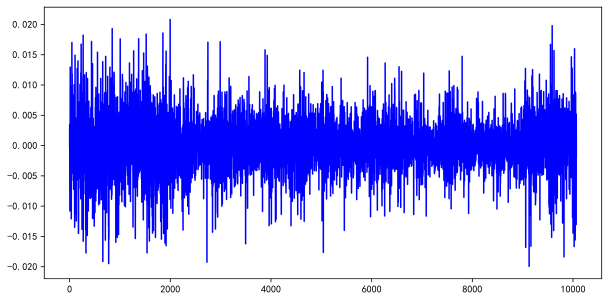

In [24]:
all_signal = load(SAVE_PATH+"\\all_signals\\"+ product_list[0]+ ".ret."+str(period)+".pkl")
vanish_signal = vanish_thre(all_signal, 0.021)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
plt.figure(1, figsize=(10, 5))
plt.plot(vanish_signal, color='b')

kurtosis= 4.0562037454864335  skew= -0.04507036426563965


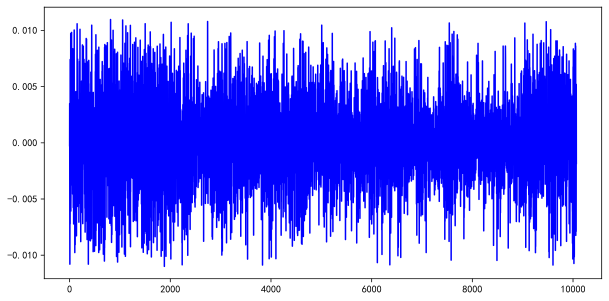

In [25]:
all_signal = load(SAVE_PATH+"\\all_signals\\"+ product_list[0]+ ".ret."+str(period)+".pkl")
vanish_signal = vanish_thre(all_signal, 0.011)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
plt.figure(1, figsize=(10, 5))
plt.plot(vanish_signal, color='b')

In [26]:
class factor_ret_period_002(factor_template):
    factor_name = "ret.period.002"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.021).values
    
y2 = factor_ret_period_002()

In [27]:
for product in product_list:
    create_signal_path(y2, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\ret.4096.002
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\ret.4096.002
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\ret.4096.002
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\ret.4096.002
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\ret.4096.002


In [28]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+ "\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y2, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 2min


In [29]:
class factor_ret_period_001(factor_template):
    factor_name = "ret.period.001"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.011).values
    
y3 = factor_ret_period_001()


In [30]:
for product in product_list:
    create_signal_path(y3, product, SAVE_PATH)

D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\rb\ret.4096.001
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\hc\ret.4096.001
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\i\ret.4096.001
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\j\ret.4096.001
D:\self_learning_python\self_learning\My_Strategies_CTA\factor_pkl\jm\ret.4096.001


In [31]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+ "\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y3, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 2min 3s


In [32]:
sum(train_sample)

487

In [33]:
sum(test_sample)

576

In [34]:
def count_daily_num(x, period):
    data = load(x)
    return np.floor(sum(data["good"])/period)

In [35]:
os.makedirs(HEAD_PATH+"\\daily_num", exist_ok=True)

In [36]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+ "\\" + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    daily_num = pd.Series(parLapply(CORE_NUM, file_list, count_daily_num, period=period))
    save(daily_num, HEAD_PATH+"\\daily_num\\"+product+".pkl")

Wall time: 1min 42s


In [37]:
daily_num = load(HEAD_PATH+"\\daily_num\\"+product+".pkl")


In [38]:
n_train = sum(daily_num[train_sample])
n_train

3403.0

In [39]:
n_signal = len(signal_list)
n_signal

45

In [45]:
## construct the signal matrix
## we want to put multiple signals into a matrix
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample]) ## tottal number of samples
    n_days = sum(sample)  ## number of days
    n_signal = len(signal_list) ## number of signals, the matrix would be n_samples*n_signal
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        #data = load(HEAD_PATH+"\\factor_pkl\\"+product+"\\"+file)
        good = load(SAVE_PATH + "\\good_pkl\\" + product +"\\"+file)
        chosen = (np.arange(sum(good))+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
            S = S[good]
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

In [40]:
os.makedirs(HEAD_PATH+"\\train_test_mat\\", exist_ok=True)

In [46]:
%%time
for product in product_list:
    daily_num = load(HEAD_PATH+"\\daily_num\\"+product+".pkl")
    train_mat = get_sample_signal(np.array(all_dates), train_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),"ret."+str(period)+".001","ret."+str(period)+".002"]), 
                                  period, daily_num)
    os.makedirs(HEAD_PATH+"\\train_test_mat\\"+product, exist_ok=True)
    save(train_mat, HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")

Wall time: 10min 28s


In [47]:
## construct the signal matrix
## we want to put multiple signals into a matrix
def get_sample_roll_std_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample]) ## tottal number of samples
    n_days = sum(sample)  ## number of days
    n_signal = len(signal_list) ## number of signals, the matrix would be n_samples*n_signal
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        #data = load(HEAD_PATH+"\\factor_pkl\\"+product+"\\"+file)
        good = load(SAVE_PATH + "\\good_pkl\\" + product +"\\"+file)
        chosen = (np.arange(sum(good))+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
            var = fast_roll_var(pd.DataFrame(S),period)
            S = S/np.sqrt(var[0])
            S = S[good]
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

In [49]:
%%time
for product in product_list:
    daily_num = load(HEAD_PATH+"\\daily_num\\"+product+".pkl")
    train_mat = get_sample_roll_std_signal(np.array(all_dates), train_sample, product, signal_list, period, daily_num)
    os.makedirs(HEAD_PATH+"\\train_test_std_mat\\"+product, exist_ok=True)
    save(train_mat, HEAD_PATH+"\\train_test_std_mat\\"+product+".train.mat.pkl")

Wall time: 16min 45s


In [50]:
import  sklearn.preprocessing
ori_mat = load(HEAD_PATH+"\\train_test_mat\\"+product_list[0]+".train.mat.pkl")
ori_mat.columns

Index(['trade.imb.4096', 'total.trade.imb.4096', 'nr.4096', 'dbook.4096',
       'range.pos.4096', 'price.osci.4096', 'ma.dif.10.4096', 'kdj.k.4096',
       'kdj.j.4096', 'trade.imb.range.4096', 'total.trade.imb.range.4096',
       'nr.range.4096', 'dbook.range.4096', 'range.pos.range.4096',
       'price.osci.range.4096', 'ma.dif.10.range.4096', 'kdj.k.range.4096',
       'kdj.j.range.4096', 'trade.imb.std.4096', 'total.trade.imb.std.4096',
       'nr.std.4096', 'dbook.std.4096', 'range.pos.std.4096',
       'price.osci.std.4096', 'ma.dif.10.std.4096', 'kdj.k.std.4096',
       'kdj.j.std.4096', 'trade.imb.volume.open.ratio.4096',
       'total.trade.imb.volume.open.ratio.4096', 'nr.volume.open.ratio.4096',
       'dbook.volume.open.ratio.4096', 'range.pos.volume.open.ratio.4096',
       'price.osci.volume.open.ratio.4096', 'ma.dif.10.volume.open.ratio.4096',
       'kdj.k.volume.open.ratio.4096', 'kdj.j.volume.open.ratio.4096',
       'trade.imb.trend.index.4096', 'total.trade.imb.tre

In [51]:
train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=ori_mat.columns)
print(product_list[0], train_mat.shape)
for product in product_list[1:]:
    cur_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=ori_mat.columns)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

rb (4809, 48)
hc (4208, 48)
i (4393, 48)
j (3639, 48)
jm (3403, 48)


In [52]:
train_mat.shape

(20452, 48)

In [53]:
import statsmodels.formula.api as smf

formula = "train_mat['ret."+str(period)+"'] ~ train_mat['nr."+str(period)+"'] + 0"
formula

"train_mat['ret.4096'] ~ train_mat['nr.4096'] + 0"

In [54]:
fit_one_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
print(fit_one_lm.summary())

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.001
Model:                               OLS   Adj. R-squared (uncentered):              0.001
Method:                    Least Squares   F-statistic:                              23.56
Date:                   Mon, 06 Jun 2022   Prob (F-statistic):                    1.22e-06
Time:                           15:54:12   Log-Likelihood:                         -29011.
No. Observations:                  20452   AIC:                                  5.802e+04
Df Residuals:                      20451   BIC:                                  5.803e+04
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-

In [55]:
def get_t_value(train_mat, signal, response):
    beta = np.sum(train_mat[signal]*train_mat[response])/sum(train_mat[signal]**2)
    sigma = np.sqrt(np.sum((train_mat[signal]*beta-train_mat[response])**2) / (len(train_mat)-1))
    v = np.sqrt(np.sum(train_mat[signal]**2))
    return beta/sigma*v

In [56]:
signal_list = np.array(signal_list)
t_stat = list(map(lambda x: get_t_value(train_mat=train_mat, signal=x, response="ret."+str(period)), signal_list))
t_stat

[-2.717155438691917,
 3.3681687975712733,
 4.854092602782139,
 -4.110099292473785,
 1.89310891475771,
 4.833654069073136,
 3.005077510135418,
 3.676907639612345,
 2.074305599731019,
 -1.9141665659986056,
 2.662269250353144,
 4.075656640165068,
 -3.184574079746343,
 0.46579687758517946,
 3.5010881838861616,
 2.657746849641886,
 2.892877644954753,
 1.3995180901516282,
 -1.8755254546811395,
 2.628207197781341,
 3.6909169301851663,
 -3.2704683768846246,
 0.8642957924405189,
 3.4191002260973216,
 1.8869415856528753,
 3.000742835743239,
 1.6732254881992972,
 -2.0505744363888634,
 2.2645257865042057,
 3.134309952150469,
 -3.4655577757519707,
 0.4570591054950775,
 3.1107719527924753,
 1.412675448359556,
 2.602747403140718,
 1.0992283682451458,
 -2.1567951447971825,
 3.557567242519503,
 4.55763147705331,
 -3.7203049030348616,
 2.115966927054354,
 4.940328903381345,
 3.43057966467667,
 3.9294633869875186,
 2.634465466956704]

In [57]:
signal_list[np.where(np.abs(t_stat)>3)]

array(['total.trade.imb.4096', 'nr.4096', 'dbook.4096', 'price.osci.4096',
       'ma.dif.10.4096', 'kdj.k.4096', 'nr.range.4096',
       'dbook.range.4096', 'price.osci.range.4096', 'nr.std.4096',
       'dbook.std.4096', 'price.osci.std.4096', 'kdj.k.std.4096',
       'nr.volume.open.ratio.4096', 'dbook.volume.open.ratio.4096',
       'price.osci.volume.open.ratio.4096',
       'total.trade.imb.trend.index.4096', 'nr.trend.index.4096',
       'dbook.trend.index.4096', 'price.osci.trend.index.4096',
       'ma.dif.10.trend.index.4096', 'kdj.k.trend.index.4096'],
      dtype='<U38')

In [58]:
good_index = signal_list[np.abs(t_stat)>3]
good_index

array(['total.trade.imb.4096', 'nr.4096', 'dbook.4096', 'price.osci.4096',
       'ma.dif.10.4096', 'kdj.k.4096', 'nr.range.4096',
       'dbook.range.4096', 'price.osci.range.4096', 'nr.std.4096',
       'dbook.std.4096', 'price.osci.std.4096', 'kdj.k.std.4096',
       'nr.volume.open.ratio.4096', 'dbook.volume.open.ratio.4096',
       'price.osci.volume.open.ratio.4096',
       'total.trade.imb.trend.index.4096', 'nr.trend.index.4096',
       'dbook.trend.index.4096', 'price.osci.trend.index.4096',
       'ma.dif.10.trend.index.4096', 'kdj.k.trend.index.4096'],
      dtype='<U38')

In [59]:
train_mat[good_index].corr()


,total.trade.imb.4096,nr.4096,dbook.4096,price.osci.4096,ma.dif.10.4096,kdj.k.4096,nr.range.4096,dbook.range.4096,price.osci.range.4096,nr.std.4096,dbook.std.4096,price.osci.std.4096,kdj.k.std.4096,nr.volume.open.ratio.4096,dbook.volume.open.ratio.4096,price.osci.volume.open.ratio.4096,total.trade.imb.trend.index.4096,nr.trend.index.4096,dbook.trend.index.4096,price.osci.trend.index.4096,ma.dif.10.trend.index.4096,kdj.k.trend.index.4096
total.trade.imb.4096,1.000000,0.858022,-0.231620,0.790742,0.773456,0.670823,0.710663,-0.232547,0.784039,0.675180,-0.238310,0.755678,0.619100,0.738164,-0.252702,0.757181,0.907730,0.779048,-0.243960,0.781783,0.688510,0.677717
nr.4096,0.858022,1.000000,-0.268513,0.866150,0.858579,0.758001,0.864415,-0.279071,0.882525,0.825269,-0.288527,0.856519,0.727725,0.899869,-0.303284,0.867685,0.854400,0.930056,-0.291540,0.877770,0.800908,0.789629
dbook.4096,-0.231620,-0.268513,1.000000,-0.319513,-0.284856,-0.230416,-0.203150,0.865415,-0.277141,-0.198137,0.820746,-0.267268,-0.209889,-0.232913,0.898871,-0.298312,-0.201602,-0.220498,0.857468,-0.271671,-0.227606,-0.210469
price.osci.4096,0.790742,0.866150,-0.319513,1.000000,0.840757,0.695045,0.652851,-0.282215,0.842055,0.614431,-0.279787,0.792108,0.587101,0.715145,-0.320791,0.895646,0.707264,0.722960,-0.298208,0.852205,0.693462,0.659106
ma.dif.10.4096,0.773456,0.858579,-0.284856,0.840757,1.000000,0.722565,0.872189,-0.318500,0.985913,0.849057,-0.329035,0.966374,0.815592,0.859758,-0.327786,0.914740,0.749133,0.794716,-0.298355,0.835236,0.915137,0.730415
kdj.k.4096,0.670823,0.758001,-0.230416,0.695045,0.722565,1.000000,0.667538,-0.261714,0.737996,0.650879,-0.274255,0.732505,0.839155,0.677416,-0.265909,0.693909,0.700981,0.744557,-0.261443,0.754608,0.694043,0.926415
nr.range.4096,0.710663,0.864415,-0.203150,0.652851,0.872189,0.667538,1.000000,-0.271694,0.903885,0.976837,-0.292847,0.905327,0.846852,0.934199,-0.265595,0.787006,0.765289,0.872198,-0.246994,0.739362,0.884947,0.730905
dbook.range.4096,-0.232547,-0.279071,0.865415,-0.282215,-0.318500,-0.261714,-0.271694,1.000000,-0.320145,-0.276732,0.978825,-0.323152,-0.297728,-0.280947,0.927290,-0.305953,-0.230431,-0.259265,0.830676,-0.277941,-0.288687,-0.258675
price.osci.range.4096,0.784039,0.882525,-0.277141,0.842055,0.985913,0.737996,0.903885,-0.320145,1.000000,0.877657,-0.332130,0.979848,0.835242,0.876741,-0.322227,0.912656,0.770799,0.823677,-0.297674,0.847271,0.914362,0.752468
nr.std.4096,0.675180,0.825269,-0.198137,0.614431,0.849057,0.650879,0.976837,-0.276732,0.877657,1.000000,-0.308303,0.917159,0.875144,0.913656,-0.265071,0.757305,0.737452,0.843414,-0.245973,0.708897,0.872271,0.715388


<AxesSubplot:>

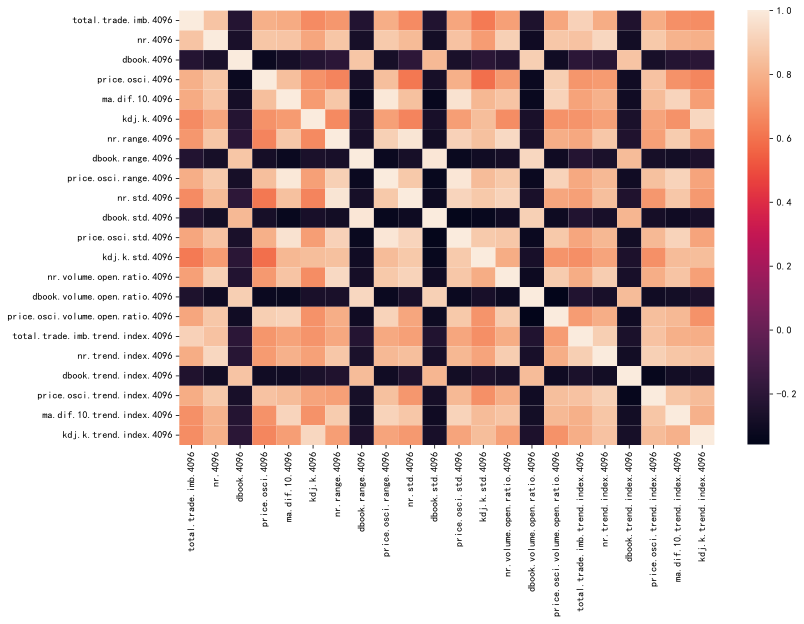

In [61]:
corr = train_mat[good_index].corr()
plt.figure(figsize=(12, 8)) 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [62]:
np.argmax(np.abs(t_stat))

41

In [63]:
signal_list[np.argmax(np.abs(t_stat))]

'price.osci.trend.index.4096'

In [64]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    chosen_signals = []
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} - 1".format("data['"+response+"']",
                                           ' + '.join(selected + ["data['"+candidate+"']"]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append("data['"+best_candidate+"']")
            current_score = best_new_score
            chosen_signals.append(best_candidate)
    formula = "{} ~ {} - 1".format("data['"+response+"']",
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return OrderedDict([("model", model), ("chosen.signals", chosen_signals)])

In [65]:
result = forward_selected(train_mat[train_mat.columns[:-2]], "ret."+str(period))

In [66]:
save(result, HEAD_PATH+"\\processed_data\\all_forward_select.pkl")

In [67]:
result = load(HEAD_PATH+"\\processed_data\\all_forward_select.pkl")

In [68]:
result["model"].model.formula

"data['ret.4096'] ~ data['price.osci.trend.index.4096'] + data['range.pos.trend.index.4096'] + data['dbook.4096'] + data['kdj.k.trend.index.4096'] + data['range.pos.volume.open.ratio.4096'] + data['nr.range.4096'] + data['ma.dif.10.volume.open.ratio.4096'] + data['ma.dif.10.range.4096'] + data['range.pos.range.4096'] + data['total.trade.imb.range.4096'] + data['nr.trend.index.4096'] + data['range.pos.std.4096'] + data['ma.dif.10.std.4096'] + data['range.pos.4096'] + data['ma.dif.10.trend.index.4096'] + data['price.osci.range.4096'] + data['price.osci.4096'] - 1"

In [69]:
result["chosen.signals"]

['price.osci.trend.index.4096',
 'range.pos.trend.index.4096',
 'dbook.4096',
 'kdj.k.trend.index.4096',
 'range.pos.volume.open.ratio.4096',
 'nr.range.4096',
 'ma.dif.10.volume.open.ratio.4096',
 'ma.dif.10.range.4096',
 'range.pos.range.4096',
 'total.trade.imb.range.4096',
 'nr.trend.index.4096',
 'range.pos.std.4096',
 'ma.dif.10.std.4096',
 'range.pos.4096',
 'ma.dif.10.trend.index.4096',
 'price.osci.range.4096',
 'price.osci.4096']

In [70]:
%%time
for product in product_list:
    daily_num = load(HEAD_PATH+"\\daily_num\\"+product+".pkl")
    test_mat = get_sample_signal(np.array(all_dates), test_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002"]), 
                                  period, daily_num)
    os.makedirs(HEAD_PATH+"\\train_test_mat\\"+product, exist_ok=True)
    save(test_mat, HEAD_PATH+"\\train_test_mat\\"+product+".test.mat.pkl")

Wall time: 11min 28s


In [71]:
%%time
for product in product_list:
    daily_num = load(HEAD_PATH+"\\daily_num\\"+product+".pkl")
    test_mat = get_sample_roll_std_signal(np.array(all_dates), test_sample, product, signal_list, period, daily_num)
    os.makedirs(HEAD_PATH+"\\train_test_std_mat\\"+product, exist_ok=True)
    save(test_mat, HEAD_PATH+"\\train_test_std_mat\\"+product+".test.mat.pkl")

Wall time: 18min 56s


In [72]:
test_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".test.mat.pkl")

In [73]:
first_signal = "price.osci.trend.index."+str(period)
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ train_mat['"+first_signal+"']+0"
formula

"train_mat['ret.4096'] ~ train_mat['price.osci.trend.index.4096']+0"

In [74]:
fit1_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
print(fit1_lm.summary())

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.001
Model:                               OLS   Adj. R-squared (uncentered):              0.001
Method:                    Least Squares   F-statistic:                              24.41
Date:                   Mon, 06 Jun 2022   Prob (F-statistic):                    7.86e-07
Time:                           16:27:29   Log-Likelihood:                         -29011.
No. Observations:                  20452   AIC:                                  5.802e+04
Df Residuals:                      20451   BIC:                                  5.803e+04
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
                                               coef    std err          t      P>|t|      

In [77]:
strat = "one."+str(period)
strat

'one.4096'

In [78]:
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

In [79]:
fit_coef = fit1_lm.params.values
fit_coef

array([0.03449145])

In [80]:
train_std = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    train_std[product] = np.std(cur_mat)

In [81]:
coef = fit_coef*train_std[product_list[0]][y_signal]/train_std[product_list[0]][first_signal]
coef

array([0.0006071])

In [82]:
%%time
for product in product_list:
    coef = fit_coef*train_std[product][y_signal]/train_std[product][first_signal]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=[first_signal], coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)

Wall time: 1min


In [83]:
%%time
for product in product_list:
    par_get_all_signal("one.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

Wall time: 21.2 s


In [85]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("one", np.array(all_dates), product, 2, 20,
                    CORE_NUM,  HEAD_PATH, SAVE_PATH, period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread*1.1, tranct_ratio=True, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 5min 37s


In [86]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+"one.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

rb train sharpe  0.6736095961924836 test sharpe  0.8107004341321653
hc train sharpe  0.2709060730865538 test sharpe  0.20261036723482398
i train sharpe  1.1957067958885188 test sharpe  -0.717875335411362
j train sharpe  0.9563231187495167 test sharpe  -0.41722096872435116
jm train sharpe  0.7888522165521208 test sharpe  0.8537297754970763


In [87]:
len(result["chosen.signals"])

17

In [88]:
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ "
n_signal = 10
for signal in result["chosen.signals"][:n_signal]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

"train_mat['ret.4096'] ~ +train_mat['price.osci.trend.index.4096']+train_mat['range.pos.trend.index.4096']+train_mat['dbook.4096']+train_mat['kdj.k.trend.index.4096']+train_mat['range.pos.volume.open.ratio.4096']+train_mat['nr.range.4096']+train_mat['ma.dif.10.volume.open.ratio.4096']+train_mat['ma.dif.10.range.4096']+train_mat['range.pos.range.4096']+train_mat['total.trade.imb.range.4096']+0"

In [89]:
fit_half_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
print(fit_half_lm.summary())

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.005
Model:                               OLS   Adj. R-squared (uncentered):              0.005
Method:                    Least Squares   F-statistic:                              10.82
Date:                   Mon, 06 Jun 2022   Prob (F-statistic):                    1.37e-18
Time:                           16:57:42   Log-Likelihood:                         -28969.
No. Observations:                  20452   AIC:                                  5.796e+04
Df Residuals:                      20442   BIC:                                  5.804e+04
Df Model:                             10                                                  
Covariance Type:               nonrobust                                                  
                                                    coef    std err          t      P>|t| 

In [90]:
strat = "half."+str(period)
os.makedirs(HEAD_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)
fit_coef = fit_half_lm.params.values
fit_coef

array([ 0.09157697, -0.08162633, -0.02819267,  0.0209909 ,  0.06581211,
        0.06702009, -0.12147247,  0.09262523, -0.08437298, -0.02548719])

In [91]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [92]:
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

In [93]:
%%time
for product in product_list:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"][:10]]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"][:10], coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)

Wall time: 1min 34s


In [94]:
%%time
for product in product_list:
    par_get_all_signal("half.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

Wall time: 23.6 s


In [95]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("half", np.array(all_dates), product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH, period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 6min 11s


In [96]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+"half.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

rb train sharpe  0.1517913273653761 test sharpe  0.29935177010063835
hc train sharpe  1.2710490118949211 test sharpe  0.03603812068511556
i train sharpe  1.021161854477159 test sharpe  -0.6150871068898139
j train sharpe  0.7524782207767613 test sharpe  0.4551234554657001
jm train sharpe  0.7103275277923056 test sharpe  -1.038598246172348


In [97]:
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

"train_mat['ret.4096'] ~ +train_mat['price.osci.trend.index.4096']+train_mat['range.pos.trend.index.4096']+train_mat['dbook.4096']+train_mat['kdj.k.trend.index.4096']+train_mat['range.pos.volume.open.ratio.4096']+train_mat['nr.range.4096']+train_mat['ma.dif.10.volume.open.ratio.4096']+train_mat['ma.dif.10.range.4096']+train_mat['range.pos.range.4096']+train_mat['total.trade.imb.range.4096']+train_mat['nr.trend.index.4096']+train_mat['range.pos.std.4096']+train_mat['ma.dif.10.std.4096']+train_mat['range.pos.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['price.osci.range.4096']+train_mat['price.osci.4096']+0"

In [98]:
fit_full_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
print(fit_full_lm.summary())

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.006
Model:                               OLS   Adj. R-squared (uncentered):              0.005
Method:                    Least Squares   F-statistic:                              7.621
Date:                   Mon, 06 Jun 2022   Prob (F-statistic):                    2.67e-19
Time:                           17:05:53   Log-Likelihood:                         -28958.
No. Observations:                  20452   AIC:                                  5.795e+04
Df Residuals:                      20435   BIC:                                  5.809e+04
Df Model:                             17                                                  
Covariance Type:               nonrobust                                                  
                                                    coef    std err          t      P>|t| 

In [99]:
strat = "full."+str(period)
os.makedirs(HEAD_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)
fit_coef = fit_full_lm.params.values
fit_coef

array([ 0.09087292, -0.12015435, -0.02618598,  0.03282631, -0.00401574,
        0.14059872, -0.06505455,  0.12290938, -0.1725815 , -0.02071116,
       -0.06651367,  0.15172247, -0.12840338,  0.04594471,  0.08574027,
       -0.10921279,  0.04357739])

In [100]:
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

In [101]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"]]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"], coef=coef, strat="full.4096", HEAD_PATH=SAVE_PATH)

rb
hc
i
j
jm
Wall time: 2min 12s


In [102]:
%%time
for product in product_list:
    par_get_all_signal("full.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

Wall time: 21.6 s


In [103]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("full", np.array(all_dates), product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 6min 17s


In [104]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+"full.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

rb train sharpe  0.2845915765091665 test sharpe  -0.5201283557616344
hc train sharpe  1.7030142606317606 test sharpe  -0.3399423836845295
i train sharpe  0.863996703755678 test sharpe  -0.9716485998250894
j train sharpe  0.8144049955497178 test sharpe  0.1899815234689409
jm train sharpe  nan test sharpe  nan


In [105]:
y_signal = "ret."+str(period)+".002"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"][:10]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

"train_mat['ret.4096.002'] ~ +train_mat['price.osci.trend.index.4096']+train_mat['range.pos.trend.index.4096']+train_mat['dbook.4096']+train_mat['kdj.k.trend.index.4096']+train_mat['range.pos.volume.open.ratio.4096']+train_mat['nr.range.4096']+train_mat['ma.dif.10.volume.open.ratio.4096']+train_mat['ma.dif.10.range.4096']+train_mat['range.pos.range.4096']+train_mat['total.trade.imb.range.4096']+0"

In [106]:
fit_002_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
strat = "half.002."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)
fit_coef = fit_002_lm.params.values
fit_coef

array([ 0.09865644, -0.09623173, -0.02968547,  0.01003814,  0.02222155,
        0.06694359, -0.08386554,  0.03817952, -0.00504127, -0.04620998])

In [107]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"][:10]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"][:10], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)

rb
price.osci.trend.index.4096         0.001581
range.pos.trend.index.4096         -0.005872
dbook.4096                         -0.002522
kdj.k.trend.index.4096              0.000167
range.pos.volume.open.ratio.4096    0.004110
nr.range.4096                       0.000328
ma.dif.10.volume.open.ratio.4096   -0.379565
ma.dif.10.range.4096                0.000878
range.pos.range.4096               -0.000006
total.trade.imb.range.4096         -0.000088
dtype: float64
hc
price.osci.trend.index.4096         0.001756
range.pos.trend.index.4096         -0.006205
dbook.4096                         -0.004229
kdj.k.trend.index.4096              0.000175
range.pos.volume.open.ratio.4096    0.004968
nr.range.4096                       0.000412
ma.dif.10.volume.open.ratio.4096   -0.480786
ma.dif.10.range.4096                0.000833
range.pos.range.4096               -0.000005
total.trade.imb.range.4096         -0.000104
dtype: float64
i
price.osci.trend.index.4096         0.002004
range.pos.trend.i

In [108]:
%%time
for product in product_list:
    par_get_all_signal("half.002.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

Wall time: 20.8 s


In [109]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("half.002", np.array(all_dates), product, 2, 20,
                    CORE_NUM,  HEAD_PATH, SAVE_PATH, period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 6min 8s


In [110]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+"half.002.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

rb train sharpe  0.9300683670647467 test sharpe  0.0758632724976619
hc train sharpe  1.055723175504777 test sharpe  0.48299391445576045
i train sharpe  0.8422102826006017 test sharpe  -0.7134533473138243
j train sharpe  0.5817050690169328 test sharpe  0.6313111470763195
jm train sharpe  0.7539233623841031 test sharpe  -0.922439732545923


In [111]:
y_signal = "ret."+str(period)+".001"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"][:10]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula
fit_001_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
strat = "half.001."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)
fit_coef = fit_001_lm.params.values
fit_coef

array([ 0.08692684, -0.09352172, -0.0272393 , -0.01250435, -0.02384342,
        0.04886468, -0.01860693, -0.01533294,  0.05962613, -0.05341662])

In [112]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"][:10]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"][:10], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)

rb
price.osci.trend.index.4096         0.001128
range.pos.trend.index.4096         -0.004621
dbook.4096                         -0.001874
kdj.k.trend.index.4096             -0.000169
range.pos.volume.open.ratio.4096   -0.003571
nr.range.4096                       0.000194
ma.dif.10.volume.open.ratio.4096   -0.068193
ma.dif.10.range.4096               -0.000285
range.pos.range.4096                0.000055
total.trade.imb.range.4096         -0.000082
dtype: float64
hc
price.osci.trend.index.4096         0.001229
range.pos.trend.index.4096         -0.004792
dbook.4096                         -0.003083
kdj.k.trend.index.4096             -0.000173
range.pos.volume.open.ratio.4096   -0.004236
nr.range.4096                       0.000239
ma.dif.10.volume.open.ratio.4096   -0.084755
ma.dif.10.range.4096               -0.000266
range.pos.range.4096                0.000051
total.trade.imb.range.4096         -0.000096
dtype: float64
i
price.osci.trend.index.4096         0.001268
range.pos.trend.i

In [113]:
%%time
for product in product_list:
    par_get_all_signal("half.001.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

Wall time: 21 s


In [114]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("half.001", np.array(all_dates), product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str="201810", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 5min 6s


In [115]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+"half.001.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

rb train sharpe  0.10460598707227092 test sharpe  0.49092654487499243
hc train sharpe  1.3939902791112198 test sharpe  0.44354947177227005
i train sharpe  0.48974771091488106 test sharpe  -0.3866750526861865
j train sharpe  0.5229187600939169 test sharpe  0.35998774294848757
jm train sharpe  0.5590875688404703 test sharpe  -1.158928710916468
Wall time: 44.8 ms


In [116]:
import statsmodels.formula.api as smf
def step_aic(model, exog, endog, **kwargs):
    """
    This select the best exogenous variables with AIC
    Both exog and endog values can be either str or list.
    (Endog list is for the Binomial family.)

    Note: This adopt only "forward" selection

    Args:
        model: model from statsmodels.formula.api
        exog (str or list): exogenous variables
        endog (str or list): endogenous variables
        kwargs: extra keyword argments for model (e.g., data, family)

    Returns:
        model: a model that seems to have the smallest AIC
    """
    for key in kwargs.keys():
        df = kwargs[key]
    df_name = "df"    
    remaining = set(exog)
    
    exog = [df_name+"['"+s+"']" for s in exog]
    endog = [df_name+"['"+s+"']" for s in endog]
    
        
    # exog, endogは強制的にリスト形式に変換しておく
    exog = np.r_[[exog]].flatten()
    endog = np.r_[[endog]].flatten()
    selected = []  # 採用が確定された要因
    chosen_signals = []
    # 定数項のみのAICを計算
    formula_head = ' + '.join(endog) + ' ~ '
    formula = formula_head + '1'
    #aic = model(formula=formula, **kwargs).fit().aic
    aic = model(formula=formula, data=df).fit().aic
    print('AIC: {}, formula: {}'.format(round(aic, 3), formula))

    current_score, best_new_score = np.ones(2) * aic

    # 全要因を採択するか，どの要因を追加してもAICが上がらなければ終了
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:

            # 残っている要因を1つずつ追加したときのAICを計算
            formula_tail = ' + '.join(selected + [df_name+"['"+candidate+"']"])
            formula = formula_head + formula_tail
            #aic = model(formula=formula, **kwargs).fit().aic
            aic = model(formula=formula, data=df).fit().aic
            print('AIC: {}, formula: {}'.format(round(aic, 3), formula))

            scores_with_candidates.append((aic, candidate))

        # 最もAICが小さかった要因をbest_candidateとする
        scores_with_candidates.sort()
        scores_with_candidates.reverse()
        best_new_score, best_candidate = scores_with_candidates.pop()

        # 候補要因追加でAICが下がったならば，それを確定要因として追加する
        
        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(df_name+"['"+best_candidate+"']")
            chosen_signals.append(best_candidate)
            current_score = best_new_score

    formula = formula_head + ' + '.join(selected)
    print('The best formula: {}'.format(formula))
    #return model(formula, **kwargs).fit()
    result = OrderedDict([("model", model), ("chosen.signals", chosen_signals)])
    #return model(formula, data=df).fit()
    return result

In [117]:
fwd_model = step_aic(smf.ols, train_mat.columns[:-3], ["ret."+str(period)+".001"], data=train_mat)
# The best formula: df['ret.4096.001'] ~ df['dbook.4096'] + df['kdj.j.trend.index.4096'] + df['price.osci.trend.index.4096'] + df['range.pos.trend.index.4096'] + df['total.trade.imb.4096'] + df['kdj.j.std.4096'] + df['ma.dif.10.volume.open.ratio.4096'] + df['nr.volume.open.ratio.4096'] + df['total.trade.imb.range.4096']nd.index.4096'] + df['total.trade.imb.volume.open.ratio.4096'] + df['ma.dif.10.4096']

AIC: 58044.287, formula: df['ret.4096.001'] ~ 1
AIC: 58045.85, formula: df['ret.4096.001'] ~ df['ma.dif.10.std.4096']
AIC: 58046.129, formula: df['ret.4096.001'] ~ df['price.osci.volume.open.ratio.4096']
AIC: 58041.184, formula: df['ret.4096.001'] ~ df['trade.imb.4096']
AIC: 58041.923, formula: df['ret.4096.001'] ~ df['trade.imb.volume.open.ratio.4096']
AIC: 58045.663, formula: df['ret.4096.001'] ~ df['nr.trend.index.4096']
AIC: 58044.073, formula: df['ret.4096.001'] ~ df['range.pos.4096']
AIC: 58045.835, formula: df['ret.4096.001'] ~ df['price.osci.range.4096']
AIC: 58042.124, formula: df['ret.4096.001'] ~ df['trade.imb.trend.index.4096']
AIC: 58042.844, formula: df['ret.4096.001'] ~ df['kdj.j.volume.open.ratio.4096']
AIC: 58042.033, formula: df['ret.4096.001'] ~ df['range.pos.volume.open.ratio.4096']
AIC: 58043.651, formula: df['ret.4096.001'] ~ df['kdj.j.4096']
AIC: 58042.05, formula: df['ret.4096.001'] ~ df['range.pos.trend.index.4096']
AIC: 58045.263, formula: df['ret.4096.001'] ~

In [118]:
y_signal = "ret."+str(period)+".001"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in fwd_model["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

"train_mat['ret.4096.001'] ~ +train_mat['dbook.4096']+train_mat['kdj.j.trend.index.4096']+train_mat['price.osci.trend.index.4096']+train_mat['range.pos.trend.index.4096']+train_mat['total.trade.imb.4096']+train_mat['kdj.j.std.4096']+train_mat['ma.dif.10.volume.open.ratio.4096']+train_mat['nr.volume.open.ratio.4096']+train_mat['total.trade.imb.range.4096']+0"

In [119]:
fit_001_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns]).fit()
print(fit_001_lm.summary())

                                    OLS Regression Results                                    
Dep. Variable:     train_mat['ret.4096.001']   R-squared (uncentered):                   0.003
Model:                                   OLS   Adj. R-squared (uncentered):              0.003
Method:                        Least Squares   F-statistic:                              7.003
Date:                       Mon, 06 Jun 2022   Prob (F-statistic):                    3.62e-10
Time:                               17:29:56   Log-Likelihood:                         -28997.
No. Observations:                      20452   AIC:                                  5.801e+04
Df Residuals:                          20443   BIC:                                  5.808e+04
Df Model:                                  9                                                  
Covariance Type:                   nonrobust                                                  
                                                  

In [120]:
strat = "full.001."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)
fit_coef = fit_001_lm.params.values
fit_coef

array([-0.02549637, -0.08328822,  0.09570154, -0.04789405, -0.01330461,
        0.08553509, -0.06028342,  0.04218698, -0.03905322])

In [121]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][fwd_model["chosen.signals"]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=fwd_model["chosen.signals"], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)

rb
dbook.4096                         -0.001754
kdj.j.trend.index.4096             -0.001342
price.osci.trend.index.4096         0.001242
range.pos.trend.index.4096         -0.002366
total.trade.imb.4096               -0.000727
kdj.j.std.4096                      0.000104
ma.dif.10.volume.open.ratio.4096   -0.220933
nr.volume.open.ratio.4096           0.030054
total.trade.imb.range.4096         -0.000060
dtype: float64
hc
dbook.4096                         -0.002886
kdj.j.trend.index.4096             -0.001384
price.osci.trend.index.4096         0.001353
range.pos.trend.index.4096         -0.002454
total.trade.imb.4096               -0.000856
kdj.j.std.4096                      0.000094
ma.dif.10.volume.open.ratio.4096   -0.274591
nr.volume.open.ratio.4096           0.047232
total.trade.imb.range.4096         -0.000070
dtype: float64
i
dbook.4096                         -0.001654
kdj.j.trend.index.4096             -0.001437
price.osci.trend.index.4096         0.001396
range.pos.trend.i

In [122]:
%%time
for product in product_list:
    par_get_all_signal("full.001.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

Wall time: 20.8 s


In [124]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("full.001", np.array(all_dates), product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH, period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 5min 11s


In [125]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+"full.001.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

rb train sharpe  1.2056997220686843 test sharpe  0.9868643135771108
hc train sharpe  1.031355945122461 test sharpe  0.910865900520958
i train sharpe  0.6828356557817103 test sharpe  -0.2632309505984836
j train sharpe  nan test sharpe  nan
jm train sharpe  0.7414970937263726 test sharpe  -0.37205917087770135


In [126]:
coef_list = dict([])
each_signal = dict([])
for product in product_list:
    train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    result = forward_selected(train_mat[train_mat.columns[:-2]], "ret."+str(period))
    y_signal = "ret."+str(period)
    formula = "train_mat['" + y_signal+"'] ~ "
    for signal in result["chosen.signals"]:
        formula = formula+"+train_mat['"+signal+"']"
    formula+="+0"
    fit_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
    coef = fit_lm.params.values
    coef_list[product] = coef
    each_signal[product] = result["chosen.signals"]
    

In [127]:
save([coef_list, each_signal], HEAD_PATH+"\\processed_data\\each_coef.pkl")

In [128]:
coef_list, each_signal = load(HEAD_PATH+"\\processed_data\\each_coef.pkl")

In [129]:
%%time
strat = "each.4096"

for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)
    print(product)
    coef = coef_list[product]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=each_signal[product], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)

rb
[-5.20399488e-04 -2.56851195e-05  9.33905177e-04  3.03010311e-03
 -2.08670288e-02  4.32663553e-03 -1.00664079e-02 -1.12244829e-04
 -1.26293478e-01  1.07136009e-02 -1.84815079e-04  1.62252253e-02
  3.26957911e-03 -5.49697972e-01]
hc
[-0.00612037  0.00045003 -0.00024515  0.00698943  0.00133595 -0.00191638
 -0.03004872  0.00037152  0.00932345 -0.0017279  -0.00095728  0.00567254
  0.16968156]
i
[-0.00544677 -0.03007315  0.00141386 -0.01083086 -0.00799469  0.00085291
  0.0287432   0.01175021 -0.01903608  0.02279482  0.00188543  0.00339202
 -0.00158574]
j
[ 0.00558872 -0.01145287  0.00077757 -0.02313305 -0.01423175  0.00092896
 -0.30231203  0.66081416  0.00098211  0.01285887 -0.00087674  0.00265298
 -0.00125535  0.11107077]
jm
[-0.0097319  -0.00197199  0.00876873 -0.05521877 -0.01309003 -0.0167021
 -0.68799876  0.00333741 -0.05383122  0.31338385  0.00235955 -0.23120919
 -0.06398426]
Wall time: 1min 50s


In [130]:
%%time
for product in product_list:
    par_get_all_signal("each.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

Wall time: 21.5 s


In [ ]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("full.001", np.array(all_dates), product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH, period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

In [136]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("each", np.array(all_dates), product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH, period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 6min 18s


In [137]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+"each.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

rb train sharpe  0.8162379911453114 test sharpe  0.23596479719503843
hc train sharpe  1.1357336874820168 test sharpe  -0.09060576627605417
i train sharpe  0.9575537298352357 test sharpe  0.10811481361520488
j train sharpe  0.7726414663535697 test sharpe  0.2836046558174308
jm train sharpe  nan test sharpe  nan
